# Infer ***cytosol*** -  3️⃣
(🚨🚨🚨🚨 Steps 4-9 depend on establishing a good solution here.)

--------------

## OBJECTIVE:  
### Infer sub-cellular component #3: ***cytosol***  in order to understand interactome 

To measure shape, position, and size of the cytosol of the cell body -- the cytosol minus the nucleus.    

Dependencies:
The ***cytoso*** inference rely on the ***nuclei*** AND ***cytosol*** inference.  Therefore all of the sub-cellular objects rely on this segmentation.



## preamble

1. imports
2. setup
3. get nuclei
4. get cellmask mask
5. get cytosol mask
6. export cytosol
7. get nuclues
8.  export nucleus



## IMPORTS

In [2]:
# top level imports
from pathlib import Path
import os, sys

import numpy as np

from skimage.morphology import binary_erosion

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)
from infer_subc_2d.core.img import *
from infer_subc_2d.organelles import infer_cellmask_fromaggr, fixed_infer_cellmask_fromaggr, infer_nuclei_fromlabel, get_cellmask

%load_ext autoreload
%autoreload 2



## SETUP

In [3]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )                       

In [4]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [5]:

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET inferred NUCLEI



In [6]:

nuclei =  infer_nuclei_fromlabel(img_data,meta_dict, out_data_path)



>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.03) sec
loaded  inferred 3D `nuclei`  from /Users/ahenrie/Projects/Imaging/data/out 


## GET SOMA MASK

Find the cellmask in our chozed Z-slice

In [8]:
# # soma_fname = "/Users/ahenrie/Projects/Imaging/data/out/soma_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.ome.tiff"
# cellmask = import_inferred_organelle("cellmask", meta_dict, out_data_path)

# if cellmask is None:
#     cellmask = fixed_infer_cellmask_fromaggr_MCZ(img_data, nuclei)
#     out_file_n = export_inferred_organelle(cellmask, "cellmask", meta_dict, out_data_path)
#     print(f"calculated cellmask. wrote {out_file_n}")
# else:
#     print(f"loaded cellmask from {out_data_path}")

cellmask = get_cellmask(img_data, nuclei, meta_dict, out_data_path)



`cellmask` object not found: /Users/ahenrie/Projects/Imaging/data/out/cellmask_ZSTACK_PBTOhNGN2hiPSCs_BR3_N04_Unmixed.tiff
starting segmentation...
shape in_img (8, 16, 768, 768)
shape nuclei_obj (16, 768, 768)
weighted_aggregate: shape in- (8, 16, 768, 768) , shape_out- (16, 768, 768)
shape struct_img (16, 768, 768)
>>>>>>>>>>>> tifffile.imwrite in (0.04) sec
saved file: None
inferred (and exported) cellmask in (25.79) sec


##  infer ***cytosol***

## summary of steps

➡️ INPUT
- labeled ***nuclei*** (objective #1)
- labeled ***cellmask*** (objective #2)

PRE-PROCESSING
- N/A

CORE PROCESSING
- mask nuclei with ***cellmask*** for ***nucleus***
- erode ***nucleus*** (shrink)
  - XOR(***nucleus***, ***cellmask***)

POST-PROCESSING
  - N/A

OUTPUT ➡️ 
- mask of ***cytosol***
- ***cytosol*** object (intensity)


## CORE PROCESSING

In [9]:
###################
# CORE_PROCESSING
###################
nucleus_obj =  apply_mask(nuclei, cellmask) 

nucleus_eroded = binary_erosion(nucleus_obj)  

cyto_object = np.logical_and(cellmask,~nucleus_eroded)
cyto_object_xor = np.logical_xor(cellmask,nucleus_eroded)

#cyto_object = binary_dilation(cyto_object)

## Visualize with `napari` 

In [10]:


viewer = napari.view_image( #viewer.add_image(
    cellmask,
    opacity=0.3,
)    


In [11]:

viewer.add_image(
    nucleus_eroded,
    opacity=0.3,
)    


<Image layer 'nucleus_eroded' at 0x16fac4c70>

In [12]:

viewer.add_image(
    nucleus_obj,
    opacity=0.3,
)    


<Image layer 'nucleus_obj' at 0x16fac4610>

In [13]:

viewer.add_image(
    cyto_object_xor,
    opacity=0.3,
)    


<Image layer 'cyto_object_xor' at 0x14cceb5e0>

## DEFINE `_infer_cytoplasm` function

Based on the _prototyping_ above define the function to infer cytosol.  


In [14]:
# copy this to base.py for easy import

def _infer_cytoplasm(nuclei_object, soma_mask,  erode_nuclei = True):
    """
    Procedure to infer cytosol from linearly unmixed input.

    Parameters
    ------------
    nuclei_object: 
        a 3d image containing the nuclei signal
    soma_mask: 
        a 3d image containing the cellmask signal
    erode_nuclei: 
        should we erode? Default False

    Returns
    -------------
    cytoplasm_mask 
        boolean np.ndarray
      
    """

    nucleus_obj =  apply_mask(nuclei_object, soma_mask) 

    if erode_nuclei:
        # cytoplasm_mask = np.logical_and(soma_mask, ~binary_erosion(nuclei_object))
        cytoplasm_mask = np.logical_xor(soma_mask, binary_erosion(nucleus_obj))
    else:
        # cytoplasm_mask = np.logical_and(soma_mask, ~nuclei_object)
        cytoplasm_mask = np.logical_xor(soma_mask, nucleus_obj)


    return cytoplasm_mask


--------------------------

## TEST `infer_cytoplasm` exported functions


In [15]:
from infer_subc_2d.organelles.cytosol import infer_cytoplasm

_cytoplasm_mask =  _infer_cytoplasm(nuclei, cellmask, erode_nuclei=False) 

cytoplasm_mask =  infer_cytoplasm(nuclei, cellmask, erode_nuclei=False) 


In [16]:
out_file_n = export_inferred_organelle(cytoplasm_mask, "cytosol", meta_dict, out_data_path)

>>>>>>>>>>>> tifffile.imwrite in (0.03) sec
saved file: None


## Visualize  2


In [17]:


viewer.scale_bar.visible = True
viewer.add_image(
    cytoplasm_mask,
)

viewer.add_labels(
    _cytoplasm_mask,
)


<Labels layer '_cytoplasm_mask' at 0x173490d90>

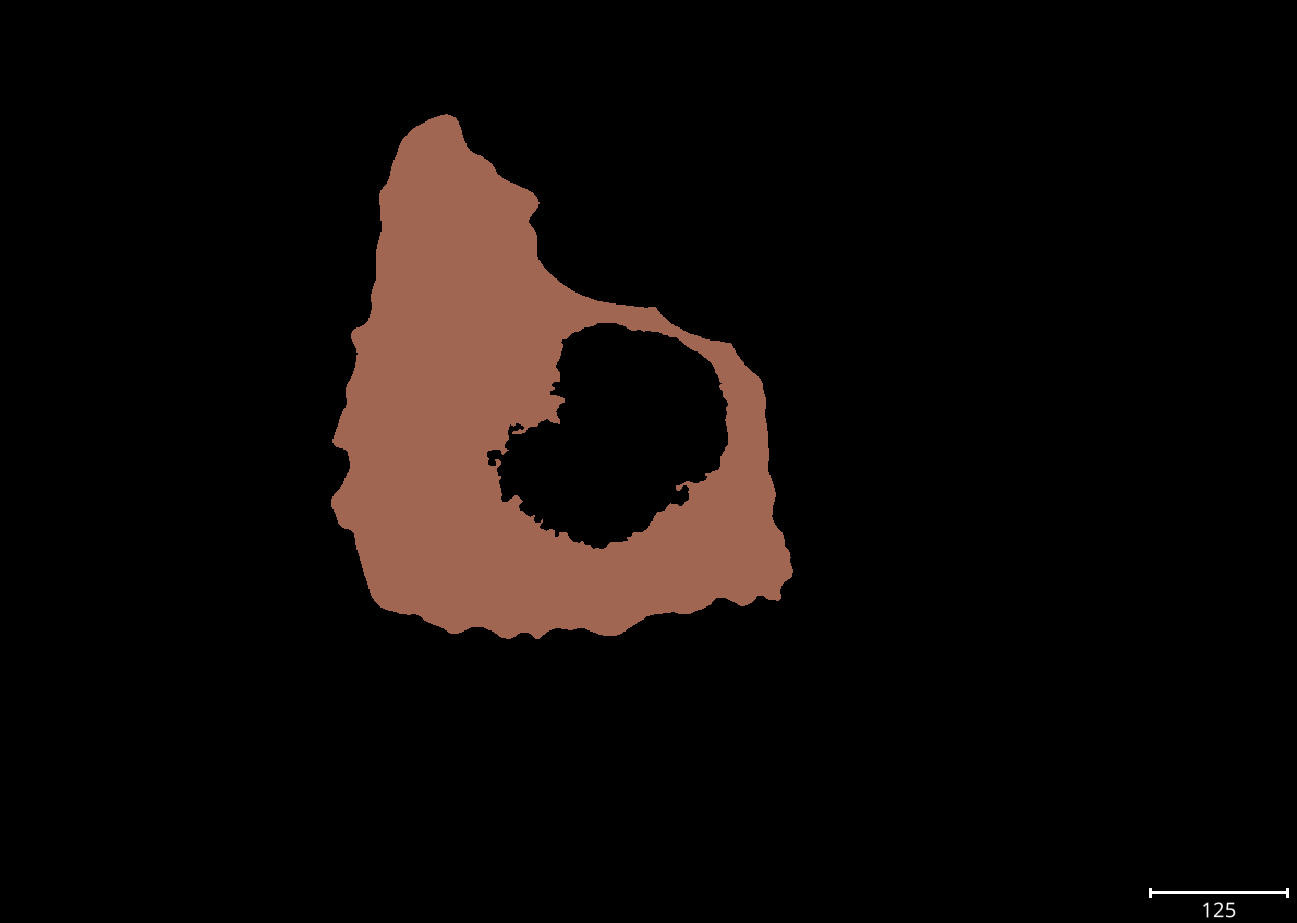

In [18]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)



In [19]:
viewer.close()

-------------
## SUMMARY

The above details how the cytosol mask is inferred. 

### NEXT: INFER LYSOSOME

proceed to [04_infer_lyso.ipynb](./04_infer_lyso.ipynb)
